In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [2]:

data_dict = {"Expected Inflation: 5 Year Breakeven Rate":"T5YIE",
            "$CPI_{Urban}$":"CPIAUCNS",
             "1 Month UST": "DGS1MO",
             "3 Month UST": "DGS3MO",
             "1 Year UST": "DGS1",
             "2 Year UST": "DGS2",
             "5 Year UST": "DGS5",
             "10 Year UST": "DGS10",
             "30 Year UST": "DGS30",   
             "5 Year TIPS":"DFII5",
             "10 Year TIPS": "DFII10",
             "Nominal GDP":"GDP",
             "Effective Federal Funds Rate (%)": "DFF",
              "Total Private Wages":"A132RC1",
             "Private Employees": "USPRIV"}

freq = "D"
start = datetime.datetime(1990, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

df = gather_data(data_dict, start, 
          end = end, freq = freq)
# df["Nominal GDP"] = df["Nominal GDP"].mul(1000)
# df["Real GDP"] = df["Real GDP"].mul(1000)

C:\Users\JLCat\AppData\Roaming\Python\Python39\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
df["Real Total Wages"] = df["Total Private Wages"].div(df["$CPI_{Urban}$"]).mul(100)
df["Average Wage"] = df["Total Private Wages"].div(df["Private Employees"])
df["Real Average Wage"] = df["Average Wage"].div(df["$CPI_{Urban}$"]).mul(100)
df["Real Wage Growth"] = df["Real Average Wage"].pct_change(12)
df["$\pi_{e_{5Y}}$"] = df["5 Year UST"].sub(df["5 Year TIPS"])
df["$\pi_{e_{10Y}}$"] = df["10 Year UST"].sub(df["10 Year TIPS"])
df["$\pi_{e_{5Y}} - \pi_{e_{10Y}}$"] = df["$\pi_{e_{5Y}}$"].sub(df["$\pi_{e_{10Y}}$"])
df["$\pi_{CPI_{Urban}}$"] = df["$CPI_{Urban}$"].pct_change(12)

C:\Users\JLCat\AppData\Local\Temp\ipykernel_20196\2523368740.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(str(y) + "%" for y in ax.get_yticks())


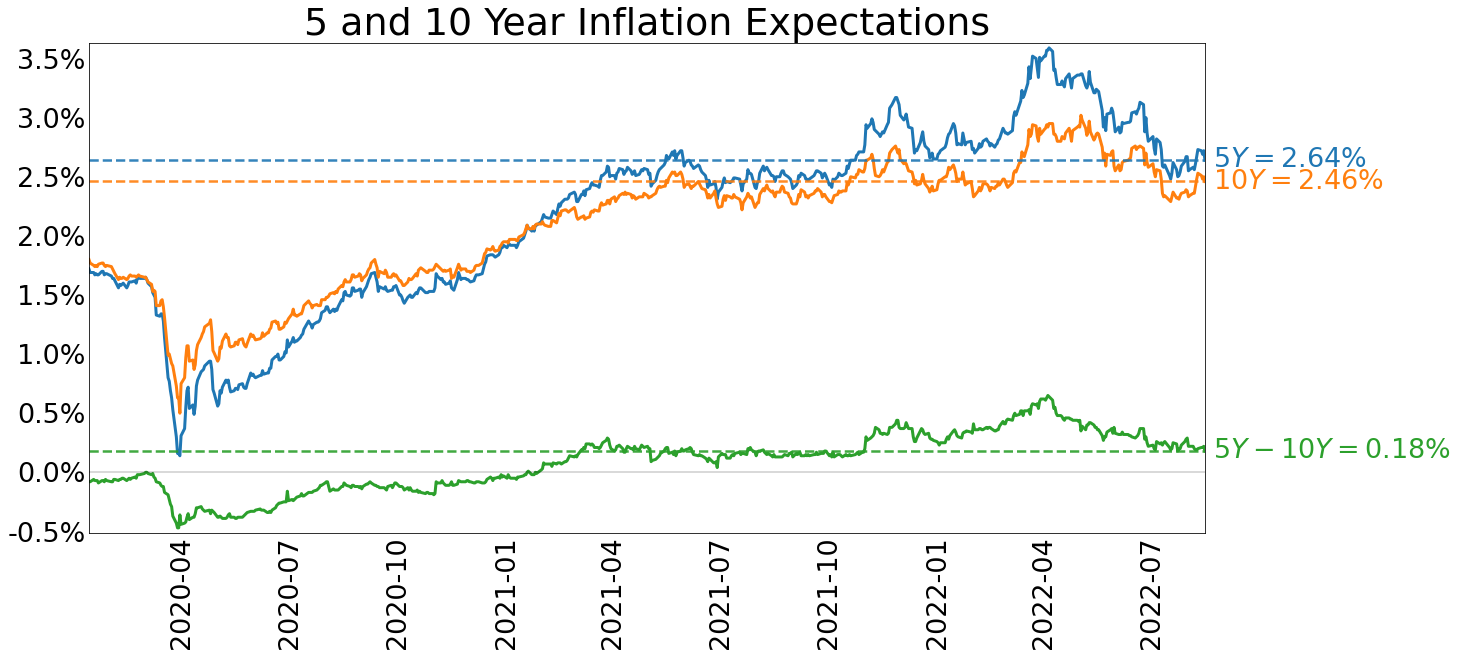

In [4]:
#### plt.rcParams.update({'font.size': 30}) 
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams['axes.xmargin'] = 0.00
plt.rcParams.update({'font.size': 27})
plot_keys =["$\pi_{e_{5Y}}$",
            "$\pi_{e_{10Y}}$",
            "$\pi_{e_{5Y}} - \pi_{e_{10Y}}$"]
plot_df = df[plot_keys].dropna().loc["2020":]
plot_df.rename(columns = {"$\pi_{e_{5Y}}$":"$5Y$",
            "$\pi_{e_{10Y}}$":"$10Y$",
            "$\pi_{e_{5Y}} - \pi_{e_{10Y}}$":"$5Y-10Y$"}, inplace = True)
plot_keys = list(plot_df.keys())
dates = list(plot_df.index)
fig, ax = plt.subplots(figsize = (20,10))
plot_df[plot_keys].plot.line(linewidth = 3, ax = ax, legend = False)#, secondary_y = "5 - 10")
ax.axhline(0, ls = "-", color = "k", alpha = .2)
ax.set_yticklabels(str(y) + "%" for y in ax.get_yticks())

for i in range(len(plot_keys)):
    
    today = plot_df[plot_keys[i]].round(2).iloc[-1]
    ax.axhline(today, ls = "--", linewidth = 2.5, color = "C" + str(i), alpha = .9)
    ax.text(dates[-1],today ,  " " + plot_keys[i] + "$=" + str(today) + "\%$", color = "C" + str(i), alpha = 1, 
            ha = "left", va = "center")
# ax.text(dates[-1],3.85 , str(list(plot_df.index)[-1])[:10], color = "k", alpha = 1,
#         ha = "left", va = "center", fontsize = 45)
ax.set_title("5 and 10 Year Inflation Expectations", fontsize = 38)
plt.xticks(rotation = 90)
ax.set_xlabel("")
ax.tick_params('both', length=0, which='both')

In [5]:
plot_df.max()

$5Y$        3.59
$10Y$       3.02
$5Y-10Y$    0.65
dtype: float64

In [6]:
plot_df["2020-03-31":].std()

$5Y$        0.733825
$10Y$       0.502621
$5Y-10Y$    0.238663
dtype: float64

<AxesSubplot:xlabel='DATE'>

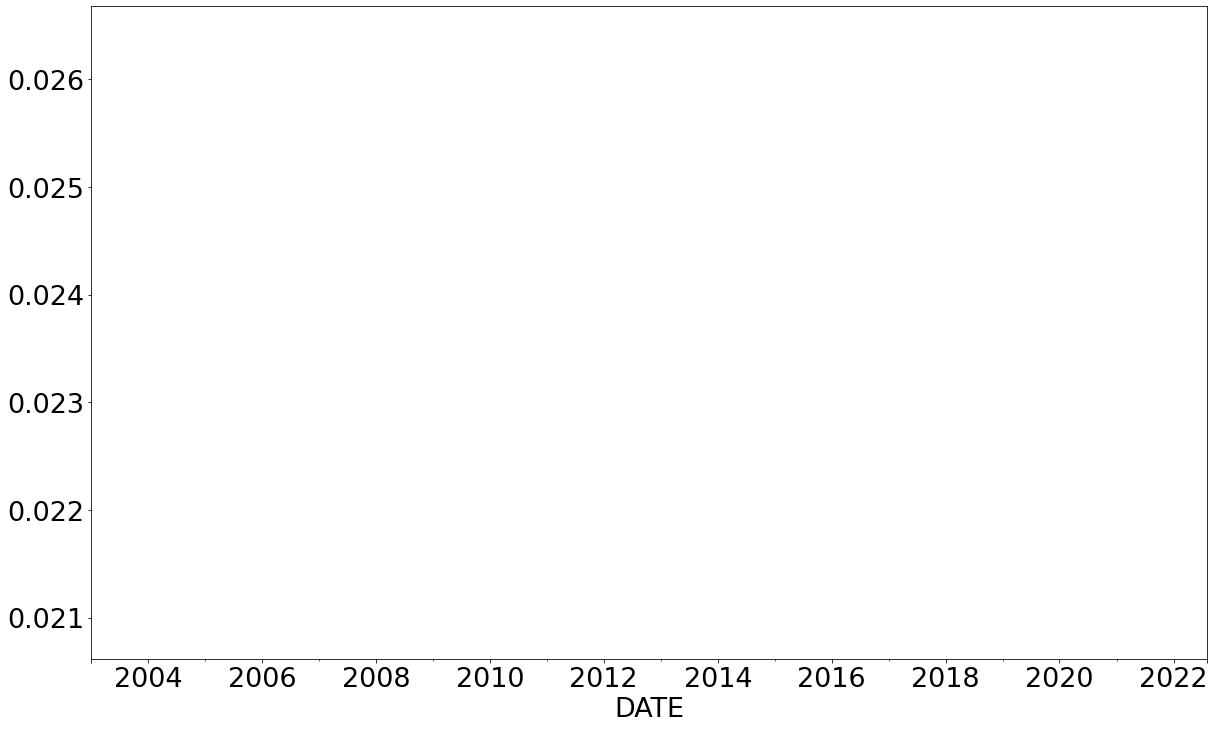

In [7]:
fig, ax = plt.subplots(figsize = (20,12))
df["Real Average Wage"].plot(ax = ax)


<AxesSubplot:xlabel='DATE'>

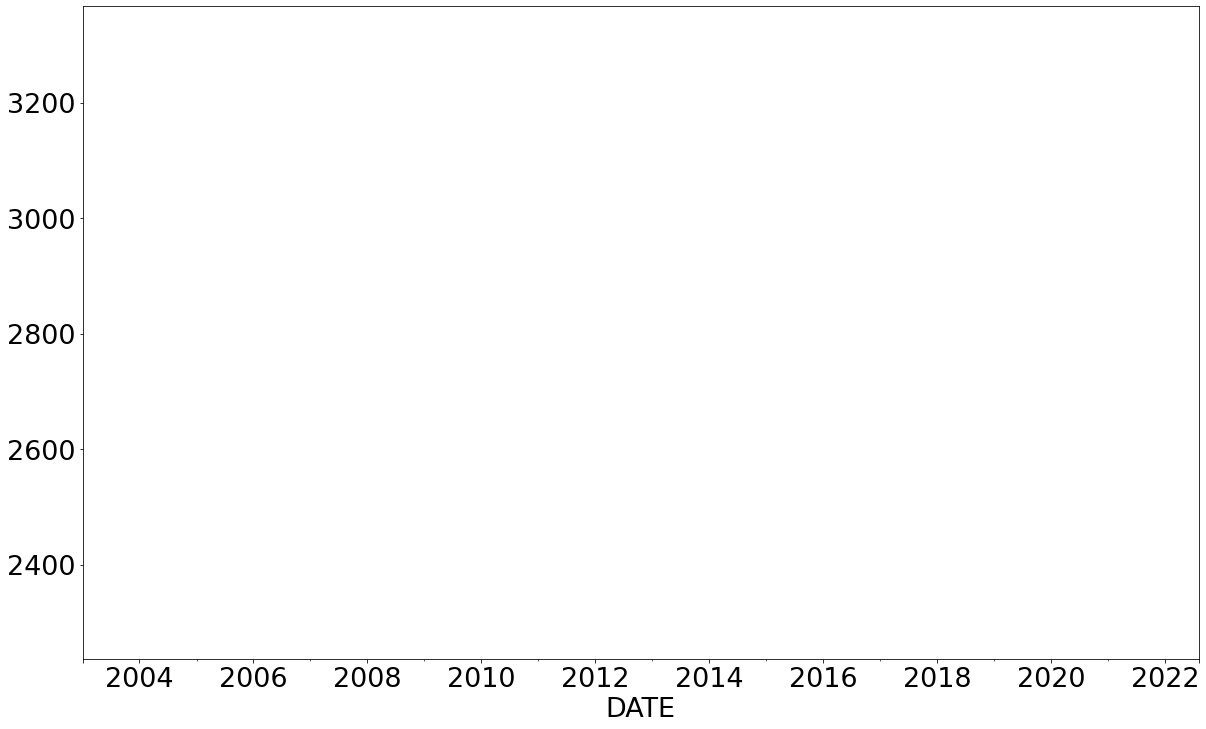

In [8]:
fig, ax = plt.subplots(figsize = (20,12))
df["Real Total Wages"].plot.line(ax = ax)

<AxesSubplot:xlabel='DATE'>

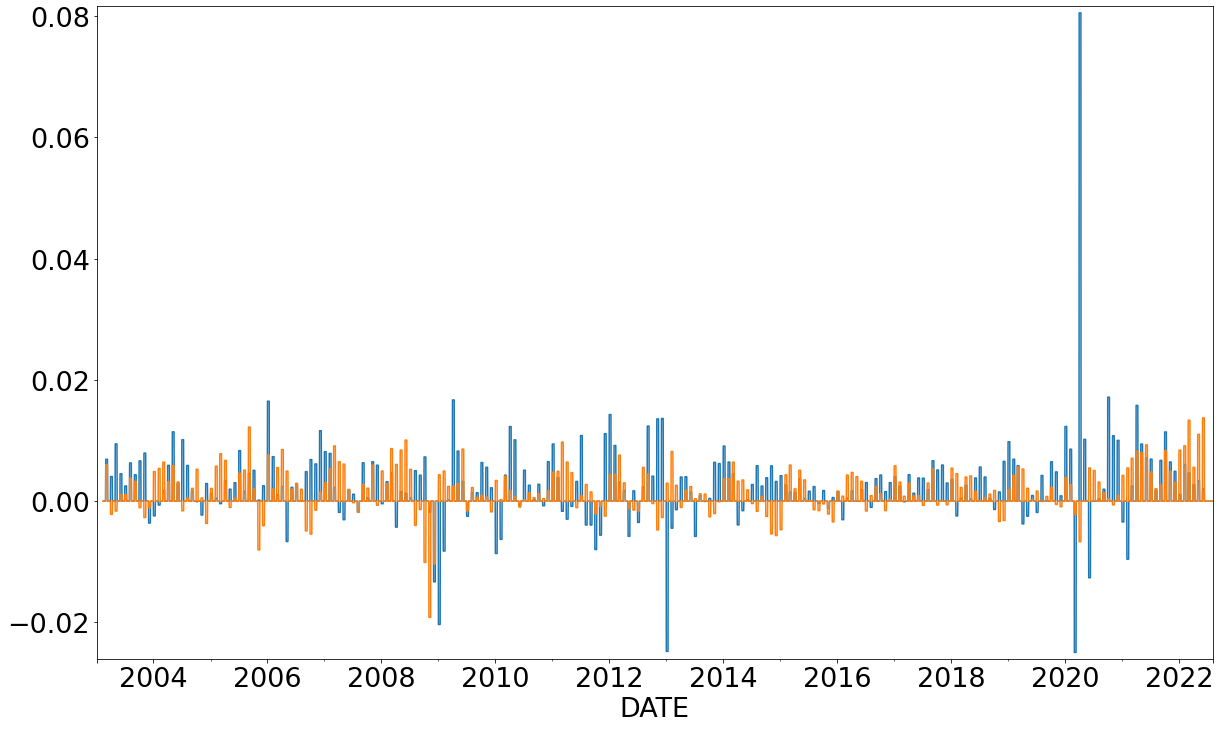

In [9]:
fig, ax = plt.subplots(figsize = (20,12))
df["Average Wage"].pct_change(12).plot.line(ax = ax)
df["$\pi_{CPI_{Urban}}$"].plot.line(ax = ax)

In [10]:
df.index

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-04', '2003-01-05',
               '2003-01-06', '2003-01-07', '2003-01-08', '2003-01-09',
               '2003-01-10', '2003-01-11',
               ...
               '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30',
               '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05'],
              dtype='datetime64[ns]', name='DATE', length=7156, freq='D')